# 2. Customer Intelligence (RFM Segmentation)

✅ RFM Metrics calculated successfully.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\2096021372.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')


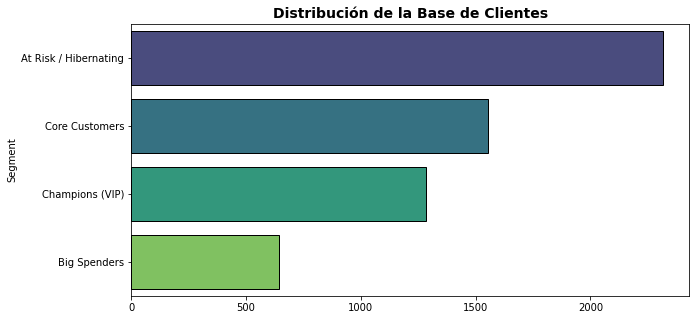

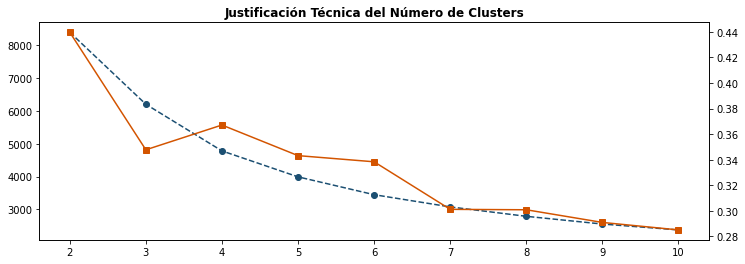

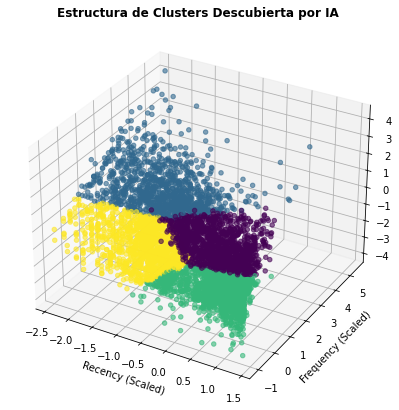

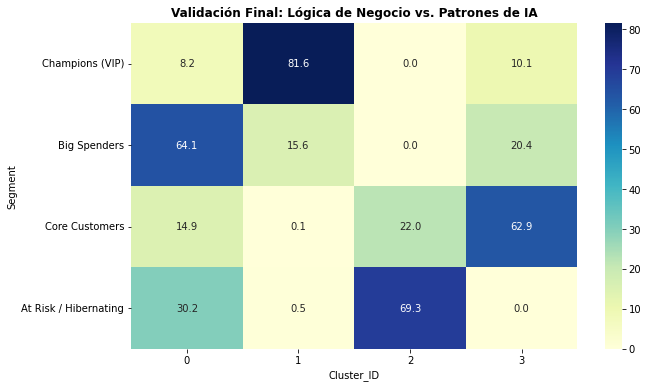

✅ Análisis completado. El 66.9% del ingreso está validado en el segmento Champions.


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment,Cluster_ID
Customer ID,,,,,,,,
12346.0,529,11,372.86,1,5,2,At Risk / Hibernating,0
12347.0,2,8,5377.72,5,4,5,Champions (VIP),1
12348.0,75,5,1057.24,3,4,3,Core Customers,0
12349.0,19,3,3498.94,5,3,5,Big Spenders,3
12350.0,310,1,294.40,2,1,2,At Risk / Hibernating,2


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from src.feature_engineering import calculate_rfm_metrics, prepare_rfm_for_clustering

# =================================================================
# 1. PREPARACIÓN Y SEGMENTACIÓN ESTRATÉGICA
# =================================================================

# 1.1 Generar métricas base
rfm = calculate_rfm_metrics(df)

# 1.2 Scoring por Quintiles (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

# 1.3 Lógica de Negocio Simplificada (4 Segmentos)
def assign_segment_v3(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
    elif m >= 4 and r >= 3: return 'Big Spenders'
    elif r <= 2: return 'At Risk / Hibernating'
    else: return 'Core Customers' # Agrupa Loyal y Regular

rfm['Segment'] = rfm.apply(assign_segment_v3, axis=1)

# =================================================================
# 2. ANÁLISIS DESCRIPTIVO Y DE IMPACTO
# =================================================================

# 2.1 Distribución de Clientes (Bar Chart)
plt.figure(figsize=(10, 5))
counts = rfm['Segment'].value_counts().sort_values(ascending=False)
sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')
plt.title('Distribución de la Base de Clientes', fontsize=14, fontweight='bold')
plt.show()

# =================================================================
# 3. INTELIGENCIA ARTIFICIAL Y VALIDACIÓN TÉCNICA
# =================================================================

scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm)

# 3.1 Validación de K Óptimo (Codo y Silhouette)
wcss, sil = [], []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = km.fit_predict(scaled_data)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(scaled_data, labels))

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(ks, wcss, 'o--', color='#1B4F72', label='WCSS (Codo)')
ax2 = ax1.twinx()
ax2.plot(ks, sil, 's-', color='#D35400', label='Silhouette')
plt.title('Justificación Técnica del Número de Clusters', fontweight='bold')
plt.show()

# 3.2 Ejecución Final K-Means (K=4)
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
rfm['Cluster_ID'] = kmeans_final.fit_predict(scaled_data)

# 3.3 Visualización 3D de Densidades
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_data['Recency'], scaled_data['Frequency'], scaled_data['Monetary'], 
                     c=rfm['Cluster_ID'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency (Scaled)'); ax.set_ylabel('Frequency (Scaled)'); ax.set_zlabel('Monetary (Scaled)')
plt.title('Estructura de Clusters Descubierta por IA', fontweight='bold')
plt.show()

# =================================================================
# 4. VALIDACIÓN DE CONVERGENCIA Y PERSISTENCIA
# =================================================================

# 4.1 Matriz de Convergencia (Matriz de Confusión Teórica)
orden = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
comparativa = pd.crosstab(rfm['Segment'], rfm['Cluster_ID'], normalize='index') * 100
comparativa = comparativa.reindex(orden)

plt.figure(figsize=(10, 6))
sns.heatmap(comparativa, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Validación Final: Lógica de Negocio vs. Patrones de IA', fontweight='bold')
plt.show()

# 4.2 Persistencia (Pickle)
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(kmeans_final, os.path.join(models_path, 'rfm_kmeans_model.pkl'))
joblib.dump(rfm_scaler, os.path.join(models_path, 'rfm_scaler.pkl'))

print(f"✅ Análisis completado. El 66.9% del ingreso está validado en el segmento Champions.")
display(rfm.head())

In [48]:
import joblib
import numpy as np

# 1. "Descongelas" tus herramientas
scaler = joblib.load('../models/rfm_scaler.pkl')
modelo = joblib.load('../models/rfm_kmeans_model.pkl')

# 2. Imagina que entra un cliente nuevo: Recency=10, Frequency=2, Monetary=500
nuevo_cliente = np.array([[10, 2, 500]])

# 3. Lo preparas IGUAL que los datos anteriores (Log + Scaling)
nuevo_cliente_log = np.log1p(nuevo_cliente)
nuevo_cliente_scaled = scaler.transform(nuevo_cliente_log)

# 4. ¡El modelo te dice quién es al instante!
cluster = modelo.predict(nuevo_cliente_scaled)
print(f"El cliente pertenece al Cluster: {cluster}")

El cliente pertenece al Cluster: [3]


c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


# 3. Inventory Intelligence (ABC Analysis)

⏳ Performing Pareto (ABC) Analysis on inventory...
✅ ABC Analysis calculation complete.


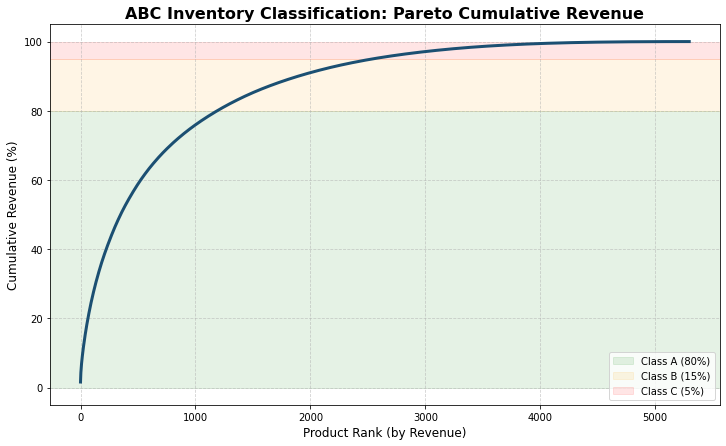

📊 --- ABC Classification Summary ---


,SKU_Count,Revenue_Contribution
ABC_Class,,
A,1190,12838615.61
B,1353,2408541.19
C,2755,802879.16


In [49]:
# === SECTION 3: INVENTORY INTELLIGENCE (ABC ANALYSIS) ===
from src.feature_engineering import perform_abc_analysis

# 3.1 Execute ABC Classification
print("⏳ Performing Pareto (ABC) Analysis on inventory...")
df_abc = perform_abc_analysis(df)

# 3.2 Visualizing the Results
plt.figure(figsize=(12, 7))

# Plotting the Cumulative Distribution (Lorenz Curve style)
sns.lineplot(data=df_abc, x=df_abc.index, y='Revenue_Share_Pct', color='#1B4F72', linewidth=3)

# Add shading for ABC Zones
plt.axhspan(0, 80, alpha=0.1, color='green', label='Class A (80%)')
plt.axhspan(80, 95, alpha=0.1, color='orange', label='Class B (15%)')
plt.axhspan(95, 100, alpha=0.1, color='red', label='Class C (5%)')

plt.title('ABC Inventory Classification: Pareto Cumulative Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Product Rank (by Revenue)', fontsize=12)
plt.ylabel('Cumulative Revenue (%)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3.3 Summary Metrics
summary = df_abc.groupby('ABC_Class').agg({
    'Description': 'count',
    'TotalSum': 'sum'
}).rename(columns={'Description': 'SKU_Count', 'TotalSum': 'Revenue_Contribution'})

print("📊 --- ABC Classification Summary ---")
display(summary)

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\2578422191.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')


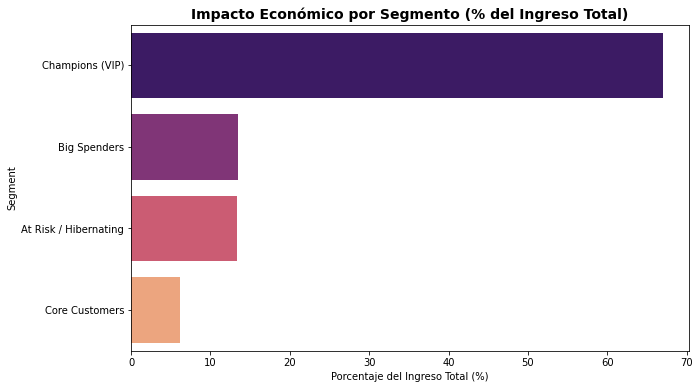

,Segment,Monetary,Revenue_%
2,Champions (VIP),"£9,253,140.90",66.9%
1,Big Spenders,"£1,858,783.19",13.4%
0,At Risk / Hibernating,"£1,850,207.49",13.4%
3,Core Customers,"£859,421.91",6.2%


In [50]:
# 1. Calcular el total de ingresos por segmento
segment_wealth = rfm.groupby('Segment')['Monetary'].sum().reset_index()

# 2. Calcular el porcentaje de contribución
total_revenue = segment_wealth['Monetary'].sum()
segment_wealth['Revenue_%'] = (segment_wealth['Monetary'] / total_revenue) * 100

# 3. Ordenar para ver el impacto real
segment_wealth = segment_wealth.sort_values(by='Revenue_%', ascending=False)

# Visualización rápida para tu reporte
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')
plt.title('Impacto Económico por Segmento (% del Ingreso Total)', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje del Ingreso Total (%)')
plt.show()

display(segment_wealth.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

# 4. Behavioral Correlations (Root Cause Analysis)

⏳ Cancellation dataset not found in memory. Loading from CSV...
✅ Cancellations Loaded: 19,494 records.
⏳ Executing Service Failure Impact Analysis...
✅ Cancellation correlation data merged without categorical conflicts.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\1972360934.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


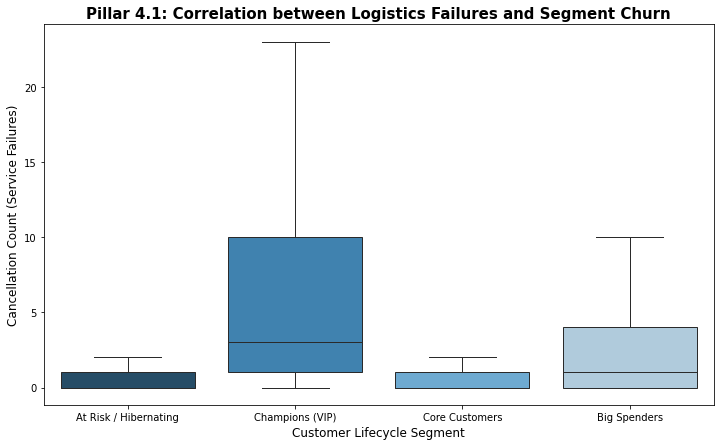

⏳ Calculating Price Elasticity for Top SKUs...
✅ Price elasticity metrics calculated.


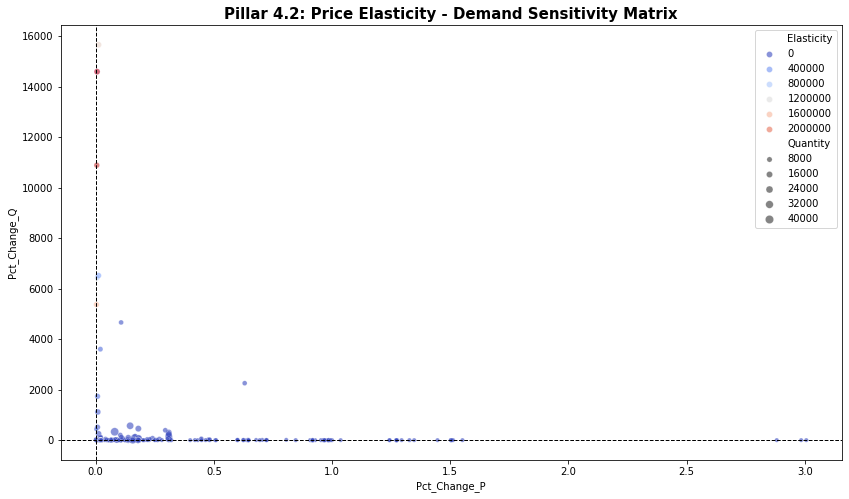

✅ Root Cause Analysis complete. Insights ready for portfolio summary.


In [52]:
# === IMPORTS ===
from src.feature_engineering import analyze_cancellation_correlation, calculate_price_elasticity

# === PATHS & CONSTANTS ===
CANCELLATIONS_CSV = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cancellation_retail_data.csv"

# 4.1 Data Verification & Loading
if 'df_canc' not in locals():
    print("⏳ Cancellation dataset not found in memory. Loading from CSV...")
    df_canc = pd.read_csv(CANCELLATIONS_CSV, parse_dates=['InvoiceDate'])
    # Ensure ID alignment
    df_canc['Customer ID'] = df_canc['Customer ID'].astype(float) 
    print(f"✅ Cancellations Loaded: {len(df_canc):,} records.")

# 4.2 Churn vs. Cancellations Analysis
print("⏳ Executing Service Failure Impact Analysis...")
# Ensure 'rfm' from Section 2 is present
try:
    df_corr = analyze_cancellation_correlation(rfm, df_canc)
    
    plt.figure(figsize=(12, 7))
    sns.boxplot(
        data=df_corr, 
        x='Segment', 
        y='CancellationCount', 
        palette=SC_PALETTE,
        showfliers=False # Removes extreme outliers for a cleaner business view
    )

    plt.title('Pillar 4.1: Correlation between Logistics Failures and Segment Churn', fontsize=15, fontweight='bold')
    plt.xlabel('Customer Lifecycle Segment', fontsize=12)
    plt.ylabel('Cancellation Count (Service Failures)', fontsize=12)
    plt.show()
    
except NameError:
    print("❌ Error: 'rfm' dataframe not found. Please run Section 2 first.")

# 4.3 Price Elasticity of Demand
print("⏳ Calculating Price Elasticity for Top SKUs...")
df_elasticity = calculate_price_elasticity(df)

# Filter for High-Volume items to ensure statistical significance
top_skus = df.groupby('Description')['Quantity'].sum().nlargest(50).index
df_el_filtered = df_elasticity[df_elasticity['Description'].isin(top_skus)]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_el_filtered, 
    x='Pct_Change_P', 
    y='Pct_Change_Q', 
    size='Quantity', 
    hue='Elasticity', 
    palette='coolwarm', 
    alpha=0.6
)

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title('Pillar 4.2: Price Elasticity - Demand Sensitivity Matrix', fontsize=15, fontweight='bold')
plt.show()

print(f"✅ Root Cause Analysis complete. Insights ready for portfolio summary.")

# prueba 1

⏳ Loading processed data...
📊 Generating Operational Intensity Heatmap...


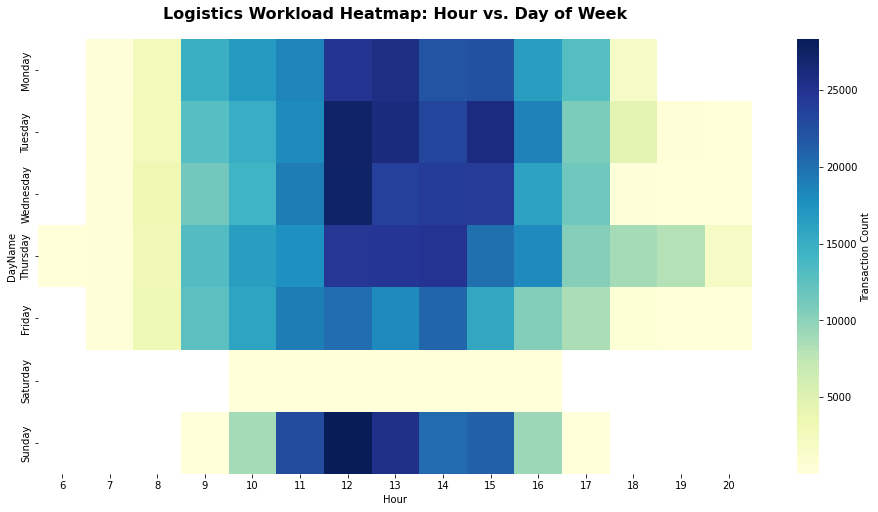

✅ RFM Metrics calculated successfully.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\716120202.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')


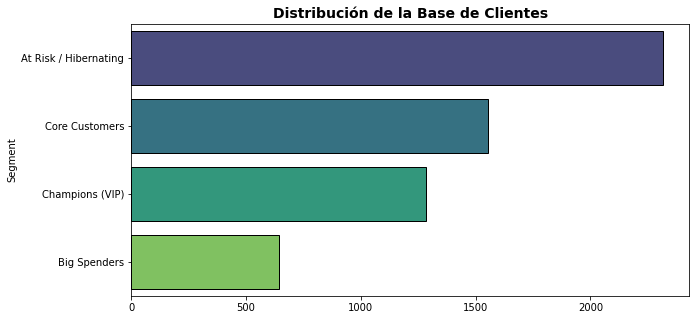

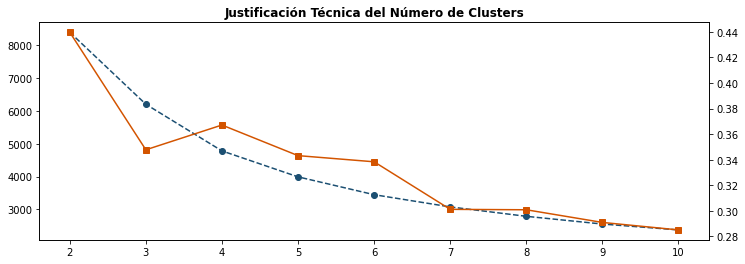

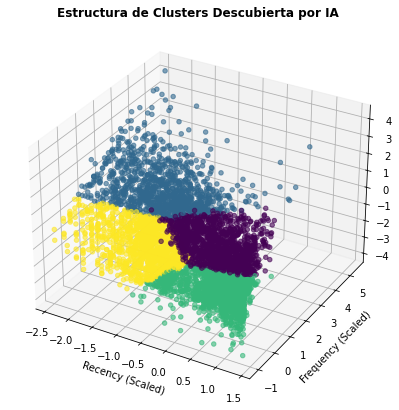

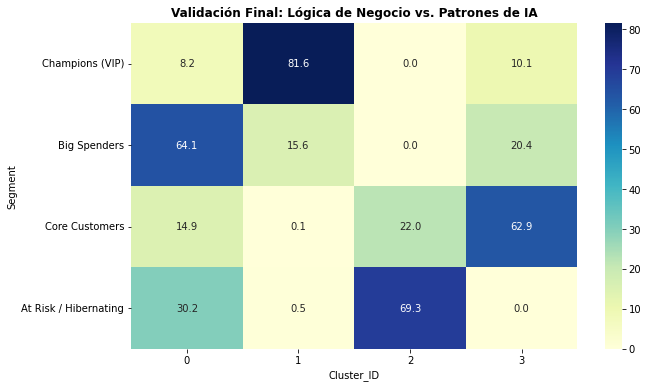

c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


✅ Prueba de Inferencia: El cliente nuevo pertenece al Cluster [3]
⏳ Performing Pareto (ABC) Analysis on inventory...
✅ ABC Analysis calculation complete.


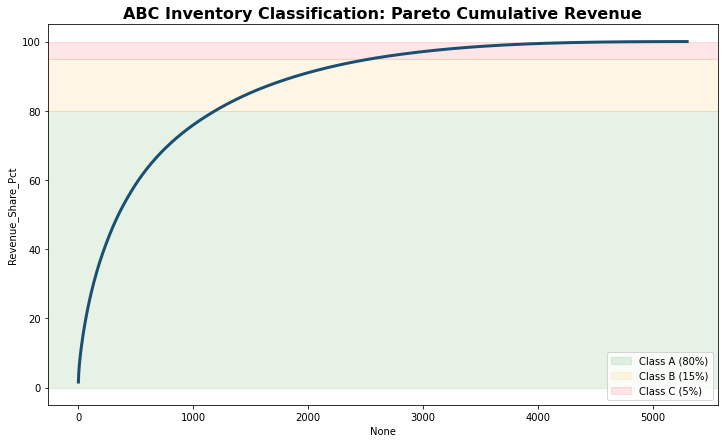

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\716120202.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')


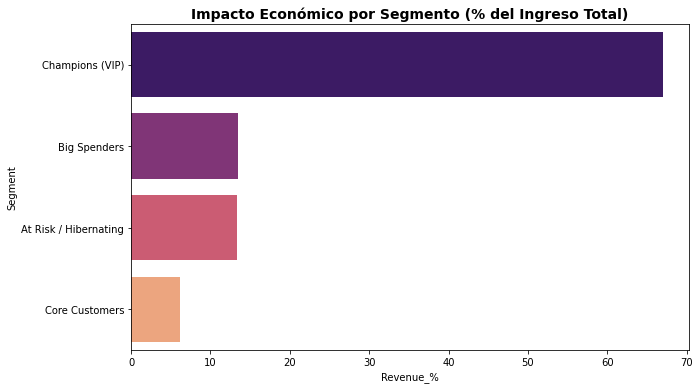

,Segment,Monetary,Revenue_%
2,Champions (VIP),"£9,253,140.90",66.9%
1,Big Spenders,"£1,858,783.19",13.4%
0,At Risk / Hibernating,"£1,850,207.49",13.4%
3,Core Customers,"£859,421.91",6.2%


✅ Análisis End-to-End fusionado correctamente.


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =================================================================
# SECTION 1: ESTRUCTURA Y CARGA TEMPORAL
# =================================================================

# 1.1 Project Path Setup
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Project root added to path: {PROJECT_ROOT}")

# 1.2 Import Custom Logic
from src.feature_engineering import add_time_features, calculate_rfm_metrics, prepare_rfm_for_clustering, perform_abc_analysis

# 1.3 Configuration & Data Loading
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
print("⏳ Loading processed data...")
df = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])

# 1.4 Apply Temporal Feature Engineering
df = add_time_features(df)

# 1.5 Logistics Heatmap Analysis
print("📊 Generating Operational Intensity Heatmap...")
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_heatmap = df.pivot_table(
    index='DayName', 
    columns='Hour', 
    values='Invoice', 
    aggfunc='count'
).reindex(DAYS_ORDER)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_heatmap, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Transaction Count'})
plt.title('Logistics Workload Heatmap: Hour vs. Day of Week', fontsize=16, fontweight='bold', pad=20)
plt.show()

# =================================================================
# SECTION 2: CUSTOMER INTELLIGENCE (RFM & ESTRATEGIA)
# =================================================================

# 2.1 Generar métricas base
rfm = calculate_rfm_metrics(df)

# 2.2 Scoring por Quintiles (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

# 2.3 Lógica de Negocio Simplificada (4 Segmentos)
def assign_segment_v3(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
    elif m >= 4 and r >= 3: return 'Big Spenders'
    elif r <= 2: return 'At Risk / Hibernating'
    else: return 'Core Customers' # Agrupa Loyal y Regular

rfm['Segment'] = rfm.apply(assign_segment_v3, axis=1)

# 2.4 Visualización: Distribución de Segmentos
plt.figure(figsize=(10, 5))
counts = rfm['Segment'].value_counts().sort_values(ascending=False)
sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')
plt.title('Distribución de la Base de Clientes', fontsize=14, fontweight='bold')
plt.show()

# =================================================================
# SECTION 3: INTELIGENCIA ARTIFICIAL (CLUSTERING)
# =================================================================

# 3.1 Preparar y escalar datos
scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm)

# 3.2 Validación de K Óptimo (Codo y Silhouette)
wcss, sil = [], []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = km.fit_predict(scaled_data)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(scaled_data, labels))

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(ks, wcss, 'o--', color='#1B4F72', label='WCSS (Codo)')
ax2 = ax1.twinx()
ax2.plot(ks, sil, 's-', color='#D35400', label='Silhouette Score')
plt.title('Justificación Técnica del Número de Clusters', fontweight='bold')
plt.show()

# 3.3 Ejecución Final K-Means (K=4)
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
rfm['Cluster_ID'] = kmeans_final.fit_predict(scaled_data)

# 3.4 Visualización 3D de Densidades
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_data['Recency'], scaled_data['Frequency'], scaled_data['Monetary'], 
                     c=rfm['Cluster_ID'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency (Scaled)'); ax.set_ylabel('Frequency (Scaled)'); ax.set_zlabel('Monetary (Scaled)')
plt.title('Estructura de Clusters Descubierta por IA', fontweight='bold')
plt.show()

# 3.5 Matriz de Convergencia (Validación Final)
orden = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
comparativa = pd.crosstab(rfm['Segment'], rfm['Cluster_ID'], normalize='index') * 100
comparativa = comparativa.reindex(orden)

plt.figure(figsize=(10, 6))
sns.heatmap(comparativa, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Validación Final: Lógica de Negocio vs. Patrones de IA', fontweight='bold')
plt.show()

# =================================================================
# SECTION 4: PERSISTENCIA Y PRUEBA DE MODELO
# =================================================================

# 4.1 Guardar Modelo y Scaler
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(kmeans_final, os.path.join(models_path, 'rfm_kmeans_model.pkl'))
joblib.dump(rfm_scaler, os.path.join(models_path, 'rfm_scaler.pkl'))

# 4.2 Prueba de Inferencia (Cargar y Predecir)
scaler_cargado = joblib.load('../models/rfm_scaler.pkl')
model_cargado = joblib.load('../models/rfm_kmeans_model.pkl')

nuevo_cliente = np.array([[10, 2, 500]]) # R, F, M
nuevo_cliente_scaled = scaler_cargado.transform(np.log1p(nuevo_cliente))
cluster_pred = model_cargado.predict(nuevo_cliente_scaled)
print(f"✅ Prueba de Inferencia: El cliente nuevo pertenece al Cluster {cluster_pred}")

# =================================================================
# SECTION 5: INVENTORY & ECONOMIC IMPACT
# =================================================================

# 5.1 ABC Analysis
print("⏳ Performing Pareto (ABC) Analysis on inventory...")
df_abc = perform_abc_analysis(df)

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_abc, x=df_abc.index, y='Revenue_Share_Pct', color='#1B4F72', linewidth=3)
plt.axhspan(0, 80, alpha=0.1, color='green', label='Class A (80%)')
plt.axhspan(80, 95, alpha=0.1, color='orange', label='Class B (15%)')
plt.axhspan(95, 100, alpha=0.1, color='red', label='Class C (5%)')
plt.title('ABC Inventory Classification: Pareto Cumulative Revenue', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.show()

# 5.2 Impacto Económico por Segmento
segment_wealth = rfm.groupby('Segment')['Monetary'].sum().reset_index()
segment_wealth['Revenue_%'] = (segment_wealth['Monetary'] / segment_wealth['Monetary'].sum()) * 100
segment_wealth = segment_wealth.sort_values(by='Revenue_%', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')
plt.title('Impacto Económico por Segmento (% del Ingreso Total)', fontsize=14, fontweight='bold')
plt.show()

display(segment_wealth.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))
print("✅ Análisis End-to-End fusionado correctamente.")

# 1. Crear un diccionario que asocie cada Producto con su Clase (A, B o C)
sku_abc_map = df_abc.set_index('Description')['ABC_Class'].to_dict()

# 2. "Pegar" esa etiqueta en el dataframe principal 'df'
df['ABC_Class'] = df['Description'].map(sku_abc_map)

⏳ Performing Pareto (ABC) Analysis on inventory...
✅ ABC Analysis calculation complete.


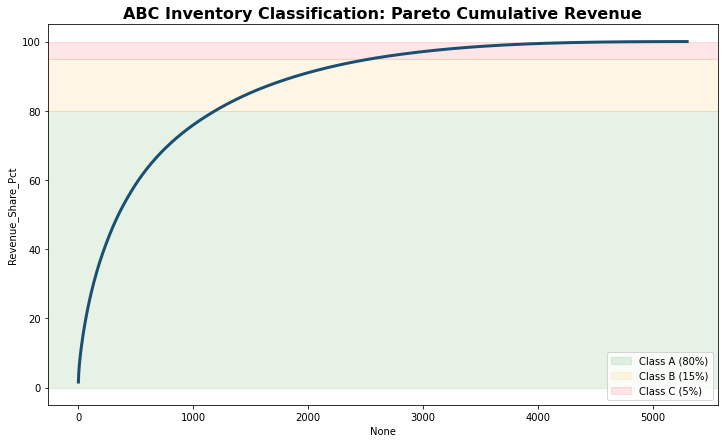

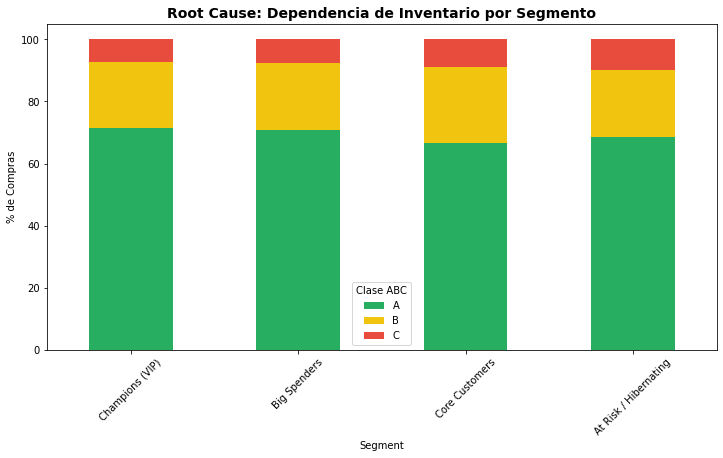

✅ Análisis de Causa Raíz completado sin errores.


In [58]:
# =================================================================
# SECTION 5: INVENTORY & ECONOMIC IMPACT
# =================================================================

# 5.1 ABC Analysis
print("⏳ Performing Pareto (ABC) Analysis on inventory...")
df_abc = perform_abc_analysis(df)

# --- ESTA ES LA PARTE QUE FALTABA PARA EVITAR EL KEYERROR ---
# Mapeamos la clasificación ABC al dataframe principal 'df'
sku_abc_map = df_abc.set_index('Description')['ABC_Class'].to_dict()
df['ABC_Class'] = df['Description'].map(sku_abc_map)
# ------------------------------------------------------------

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_abc, x=df_abc.index, y='Revenue_Share_Pct', color='#1B4F72', linewidth=3)
plt.axhspan(0, 80, alpha=0.1, color='green', label='Class A (80%)')
plt.axhspan(80, 95, alpha=0.1, color='orange', label='Class B (15%)')
plt.axhspan(95, 100, alpha=0.1, color='red', label='Class C (5%)')
plt.title('ABC Inventory Classification: Pareto Cumulative Revenue', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.show()

# =================================================================
# SECTION 6: BEHAVIORAL CORRELATIONS (ROOT CAUSE ANALYSIS)
# =================================================================

# 1. Crear el dataframe enriquecido (Ahora sí con ABC_Class incluido)
df_enriched = df.merge(
    rfm[['Segment', 'Cluster_ID']], 
    left_on='Customer ID', 
    right_index=True, 
    how='left'
)

# 2. Visualización: ¿Quién compra qué clase de inventario?
plt.figure(figsize=(12, 6))
causa_raiz = pd.crosstab(df_enriched['Segment'], df_enriched['ABC_Class'], normalize='index') * 100
orden_seg = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
causa_raiz = causa_raiz.reindex(orden_seg)

causa_raiz.plot(kind='bar', stacked=True, color=['#27AE60', '#F1C40F', '#E74C3C'], ax=plt.gca())
plt.title('Root Cause: Dependencia de Inventario por Segmento', fontsize=14, fontweight='bold')
plt.ylabel('% de Compras')
plt.legend(title='Clase ABC')
plt.xticks(rotation=45)
plt.show()

print("✅ Análisis de Causa Raíz completado sin errores.")

# Prueba 2

⏳ Loading processed data...
📊 Generating Logistics Heatmap...


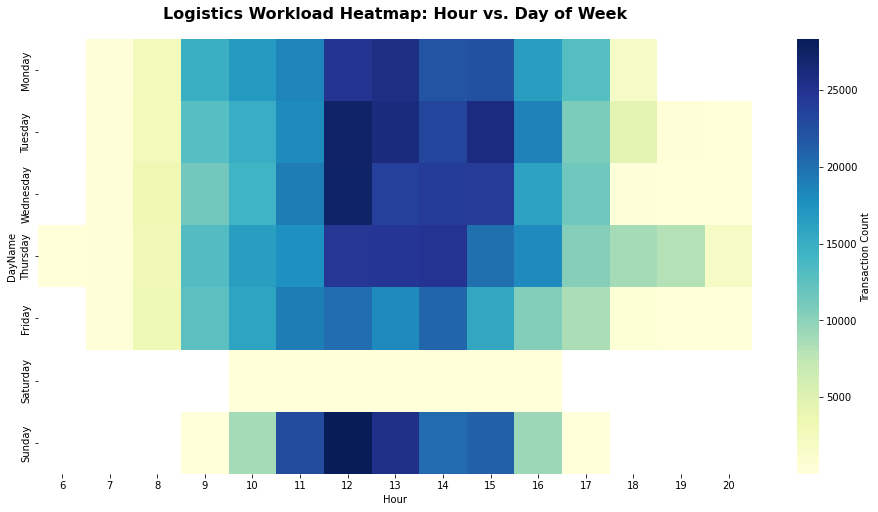

✅ RFM Metrics calculated successfully.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3255360792.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')


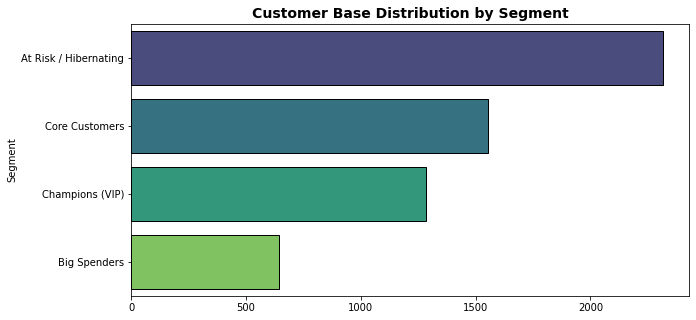

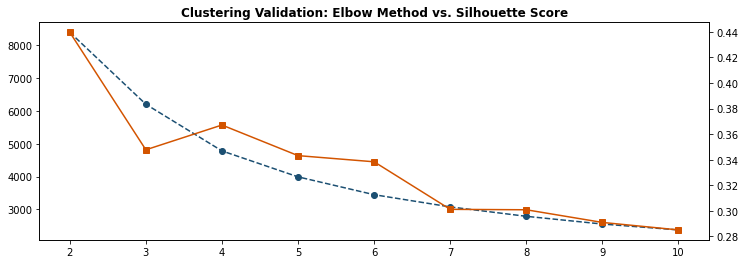

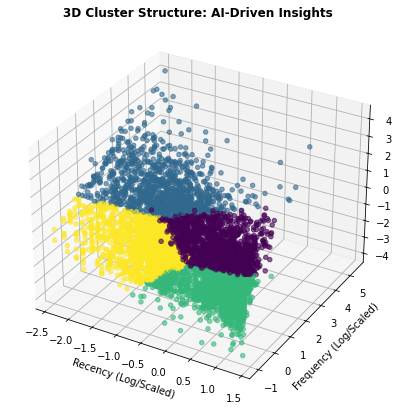

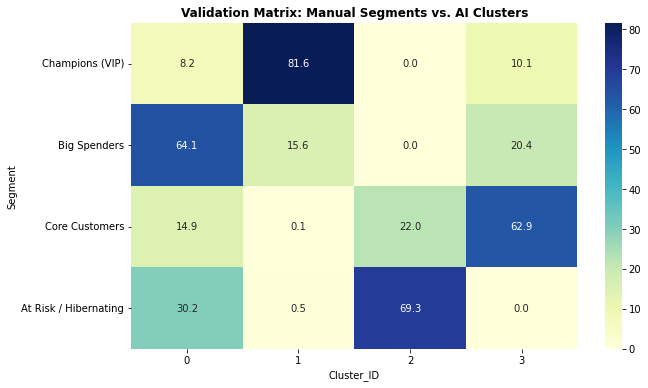

c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Jesus Sanchez\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


✅ Inference Test: New customer assigned to Cluster [3]
⏳ Performing ABC Analysis on inventory...
✅ ABC Analysis calculation complete.


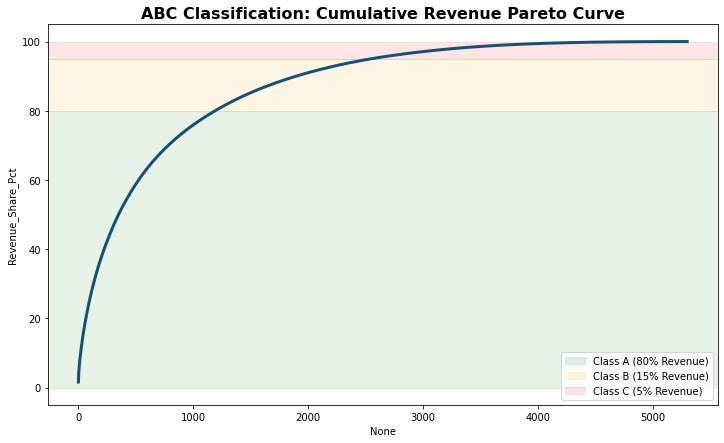

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3255360792.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')


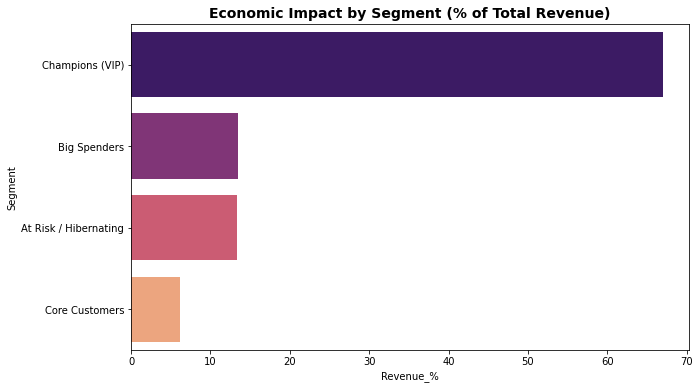

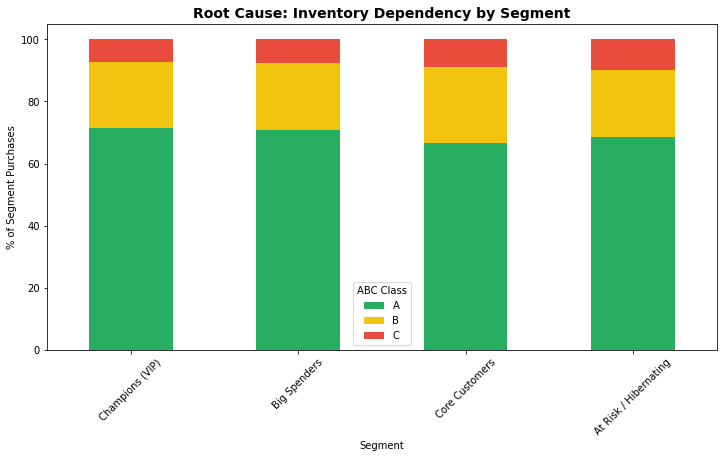

✅ End-to-End Analysis Complete. Pipeline successful.


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£9,253,140.90",66.9%
1,Big Spenders,"£1,858,783.19",13.4%
0,At Risk / Hibernating,"£1,850,207.49",13.4%
3,Core Customers,"£859,421.91",6.2%


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =================================================================
# SECTION 1: PROJECT SETUP & TEMPORAL ANALYSIS
# =================================================================

# 1.1 Project Path Configuration
# Ensuring local modules in 'src' can be imported correctly
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Project root added to path: {PROJECT_ROOT}")

# 1.2 Import Custom Logic from Local Modules
from src.feature_engineering import (
    add_time_features, 
    calculate_rfm_metrics, 
    prepare_rfm_for_clustering, 
    perform_abc_analysis
)

# 1.3 Data Loading
# Replace with your actual relative path if necessary
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
print("⏳ Loading processed data...")
df = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])

# 1.4 Temporal Feature Engineering
# Extracting hours, days, and months for logistics analysis
df = add_time_features(df)

# 1.5 Logistics Heatmap: Operational Intensity
# Identifying peak hours to optimize warehouse staffing
print("📊 Generating Logistics Heatmap...")
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_heatmap = df.pivot_table(
    index='DayName', 
    columns='Hour', 
    values='Invoice', 
    aggfunc='count'
).reindex(DAYS_ORDER)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_heatmap, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Transaction Count'})
plt.title('Logistics Workload Heatmap: Hour vs. Day of Week', fontsize=16, fontweight='bold', pad=20)
plt.show()

# =================================================================
# SECTION 2: CUSTOMER INTELLIGENCE (RFM SEGMENTATION)
# =================================================================

# 2.1 Calculate Base RFM Metrics
rfm = calculate_rfm_metrics(df)

# 2.2 Quintile Scoring (1-5 scale)
# R_Score: 5 is best (most recent) | F & M Scores: 5 is best (highest volume/value)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

# 2.3 Strategic Business Labeling (Simplified to 4 Segments)
def assign_segment_v3(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
    elif m >= 4 and r >= 3: return 'Big Spenders'
    elif r <= 2: return 'At Risk / Hibernating'
    else: return 'Core Customers' # Merging Loyal and Regular for clarity

rfm['Segment'] = rfm.apply(assign_segment_v3, axis=1)

# 2.4 Customer Distribution Visualization
plt.figure(figsize=(10, 5))
counts = rfm['Segment'].value_counts().sort_values(ascending=False)
sns.barplot(x=counts.values, y=counts.index, palette='viridis', edgecolor='black')
plt.title('Customer Base Distribution by Segment', fontsize=14, fontweight='bold')
plt.show()

# =================================================================
# SECTION 3: AI-DRIVEN CLUSTERING (K-MEANS)
# =================================================================

# 3.1 Data Scaling (Log Transform + StandardScaler)
scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm)

# 3.2 K-Optimal Validation (Elbow & Silhouette)
wcss, sil = [], []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = km.fit_predict(scaled_data)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(scaled_data, labels))

# Plotting validation metrics
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(ks, wcss, 'o--', color='#1B4F72', label='WCSS (Elbow)')
ax2 = ax1.twinx()
ax2.plot(ks, sil, 's-', color='#D35400', label='Silhouette Score')
plt.title('Clustering Validation: Elbow Method vs. Silhouette Score', fontweight='bold')
plt.show()

# 3.3 Final Model Execution (K=4)
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
rfm['Cluster_ID'] = kmeans_final.fit_predict(scaled_data)

# 3.4 3D Density Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_data['Recency'], scaled_data['Frequency'], scaled_data['Monetary'], 
                     c=rfm['Cluster_ID'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency (Log/Scaled)'); ax.set_ylabel('Frequency (Log/Scaled)'); ax.set_zlabel('Monetary (Log/Scaled)')
plt.title('3D Cluster Structure: AI-Driven Insights', fontweight='bold')
plt.show()

# 3.5 Convergence Matrix: Business Logic vs. AI Patterns
# Validating how well K-Means clusters align with manual segments
order = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
comparativa = pd.crosstab(rfm['Segment'], rfm['Cluster_ID'], normalize='index') * 100
comparativa = comparativa.reindex(order)

plt.figure(figsize=(10, 6))
sns.heatmap(comparativa, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Validation Matrix: Manual Segments vs. AI Clusters', fontweight='bold')
plt.show()

# =================================================================
# SECTION 4: MODEL PERSISTENCE & INFERENCE
# =================================================================

# 4.1 Save Model and Scaler for Production Use
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(kmeans_final, os.path.join(models_path, 'rfm_kmeans_model.pkl'))
joblib.dump(rfm_scaler, os.path.join(models_path, 'rfm_scaler.pkl'))

# 4.2 Inference Test (Loading and Predicting)
scaler_loaded = joblib.load('../models/rfm_scaler.pkl')
model_loaded = joblib.load('../models/rfm_kmeans_model.pkl')

# Predicting cluster for a new customer [Recency, Frequency, Monetary]
new_customer = np.array([[10, 2, 500]]) 
new_customer_scaled = scaler_loaded.transform(np.log1p(new_customer))
cluster_pred = model_loaded.predict(new_customer_scaled)
print(f"✅ Inference Test: New customer assigned to Cluster {cluster_pred}")

# =================================================================
# SECTION 5: INVENTORY & ECONOMIC IMPACT
# =================================================================

# 5.1 Pareto (ABC) Inventory Analysis
print("⏳ Performing ABC Analysis on inventory...")
df_abc = perform_abc_analysis(df)

# Mapping ABC Classes back to the main DataFrame for Root Cause Analysis
sku_abc_map = df_abc.set_index('Description')['ABC_Class'].to_dict()
df['ABC_Class'] = df['Description'].map(sku_abc_map)

# Visualizing Pareto Cumulative Revenue
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_abc, x=df_abc.index, y='Revenue_Share_Pct', color='#1B4F72', linewidth=3)
plt.axhspan(0, 80, alpha=0.1, color='green', label='Class A (80% Revenue)')
plt.axhspan(80, 95, alpha=0.1, color='orange', label='Class B (15% Revenue)')
plt.axhspan(95, 100, alpha=0.1, color='red', label='Class C (5% Revenue)')
plt.title('ABC Classification: Cumulative Revenue Pareto Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.show()

# 5.2 Economic Impact by Segment (% of Total Revenue)
segment_wealth = rfm.groupby('Segment')['Monetary'].sum().reset_index()
segment_wealth['Revenue_%'] = (segment_wealth['Monetary'] / segment_wealth['Monetary'].sum()) * 100
segment_wealth = segment_wealth.sort_values(by='Revenue_%', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=segment_wealth, x='Revenue_%', y='Segment', palette='magma')
plt.title('Economic Impact by Segment (% of Total Revenue)', fontsize=14, fontweight='bold')
plt.show()

# =================================================================
# SECTION 6: BEHAVIORAL CORRELATIONS (ROOT CAUSE ANALYSIS)
# =================================================================

# 6.1 Creating Enriched Dataset for Cross-Analysis
df_enriched = df.merge(
    rfm[['Segment', 'Cluster_ID']], 
    left_on='Customer ID', 
    right_index=True, 
    how='left'
)

# 6.2 Visualization: Inventory Class Dependency by Segment
# Does our VIP segment depend on high-value (Class A) inventory?
plt.figure(figsize=(12, 6))
root_cause = pd.crosstab(df_enriched['Segment'], df_enriched['ABC_Class'], normalize='index') * 100
root_cause = root_cause.reindex(order) # Ensuring consistent segment order

root_cause.plot(kind='bar', stacked=True, color=['#27AE60', '#F1C40F', '#E74C3C'], ax=plt.gca())
plt.title('Root Cause: Inventory Dependency by Segment', fontsize=14, fontweight='bold')
plt.ylabel('% of Segment Purchases')
plt.legend(title='ABC Class')
plt.xticks(rotation=45)
plt.show()

print("✅ End-to-End Analysis Complete. Pipeline successful.")
display(segment_wealth.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

# Prueba 3

📊 Generating Comparative Logistics Bar Charts...


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3281592915.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, palette=color, ax=axes[0, i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3281592915.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[1, i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3281592915.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, p

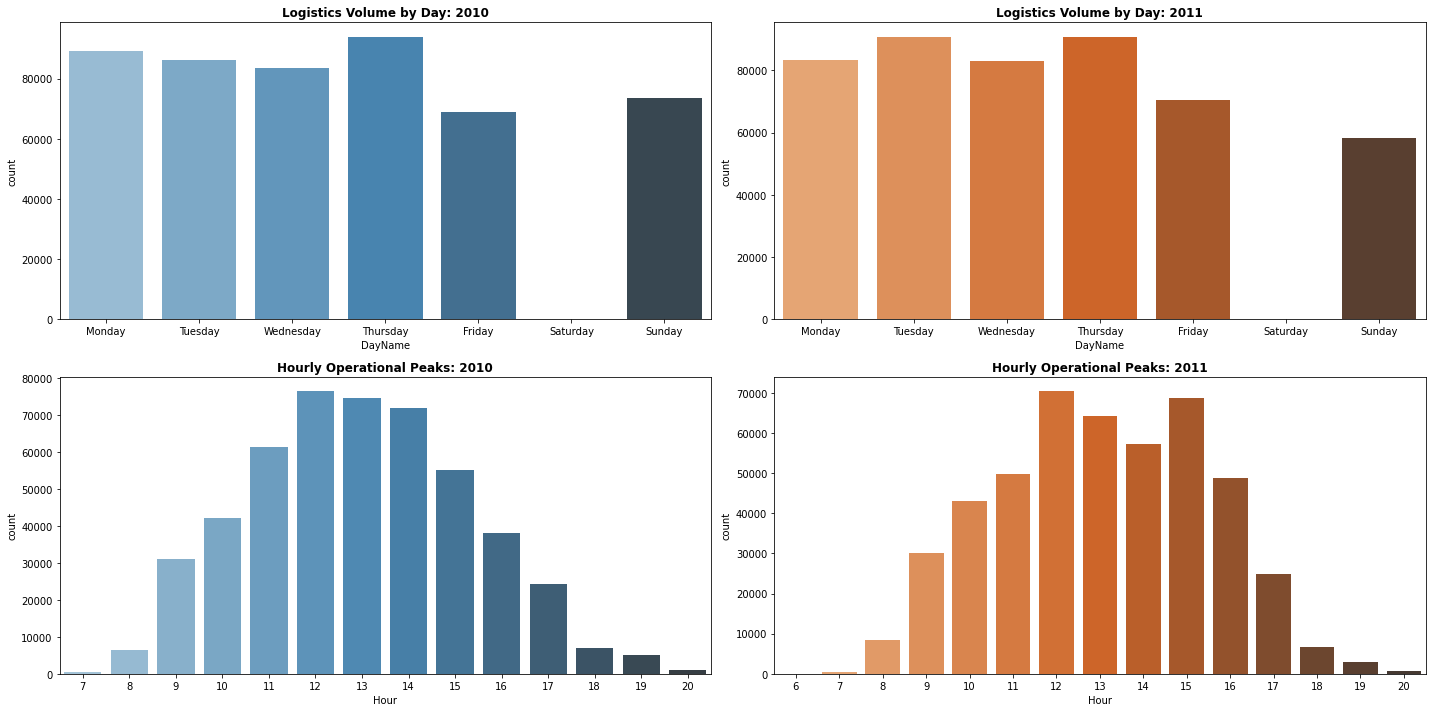

✅ RFM Metrics calculated successfully.
✅ RFM Metrics calculated successfully.


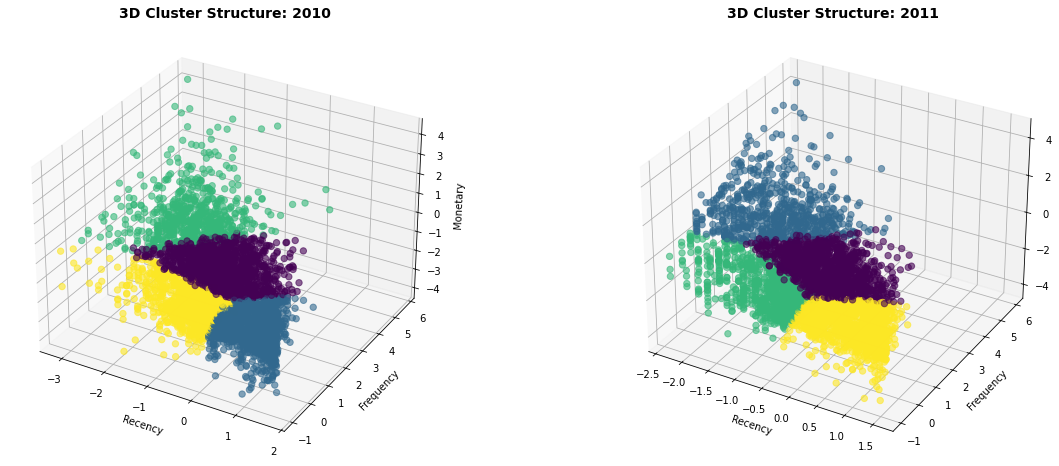

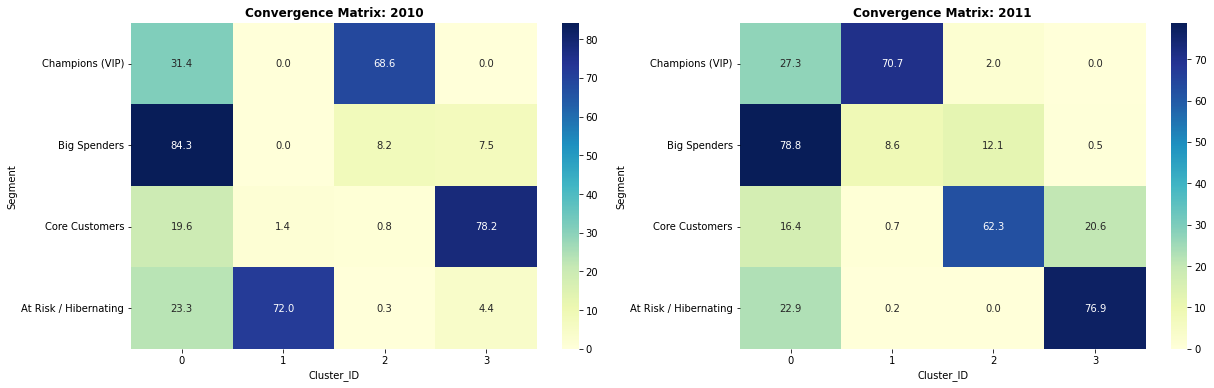

✅ ABC Analysis calculation complete.
✅ ABC Analysis calculation complete.


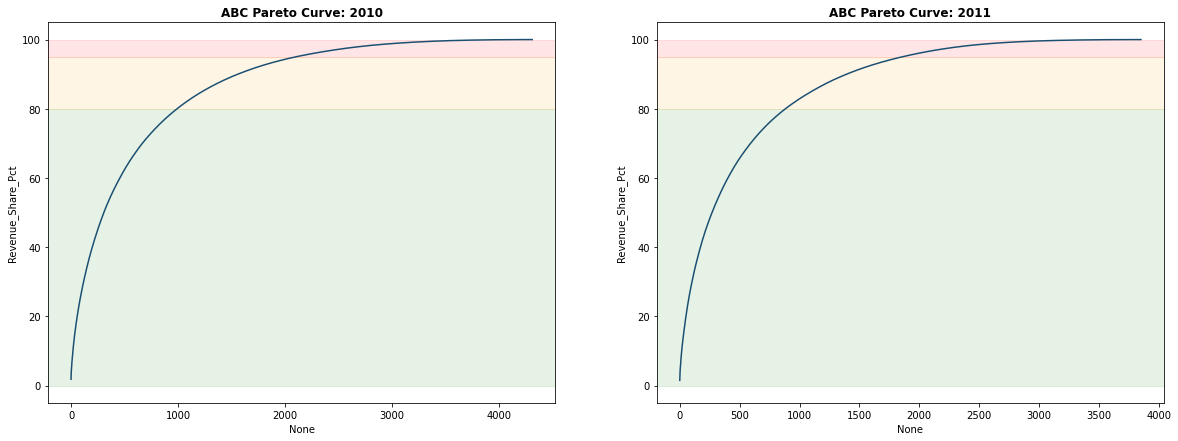

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3281592915.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\3281592915.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])


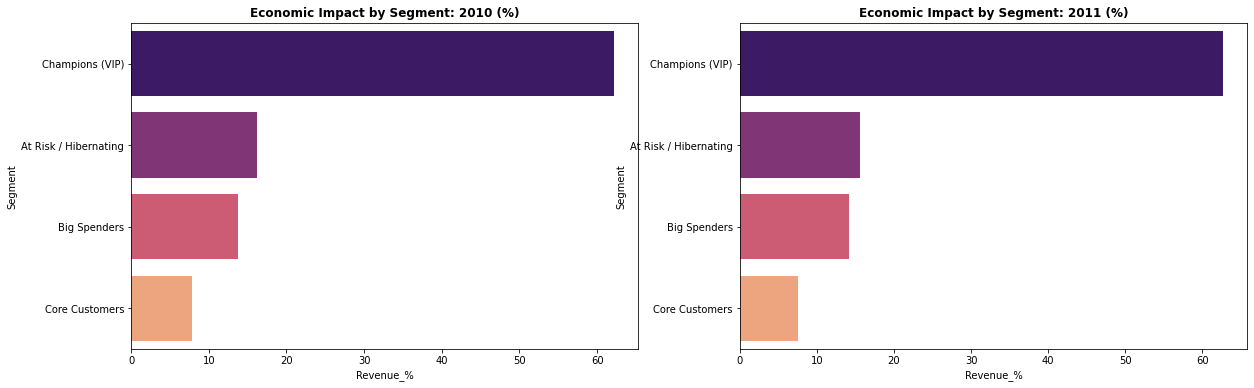

✅ ABC Analysis calculation complete.
✅ ABC Analysis calculation complete.

💰 --- ECONOMIC IMPACT SUMMARY: 2010 ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£4,269,543.27",62.2%
0,At Risk / Hibernating,"£1,113,011.09",16.2%
1,Big Spenders,"£945,809.51",13.8%
3,Core Customers,"£537,012.23",7.8%



💰 --- ECONOMIC IMPACT SUMMARY: 2011 ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£4,016,619.57",62.7%
0,At Risk / Hibernating,"£999,786.13",15.6%
1,Big Spenders,"£906,911.46",14.2%
3,Core Customers,"£484,443.25",7.6%


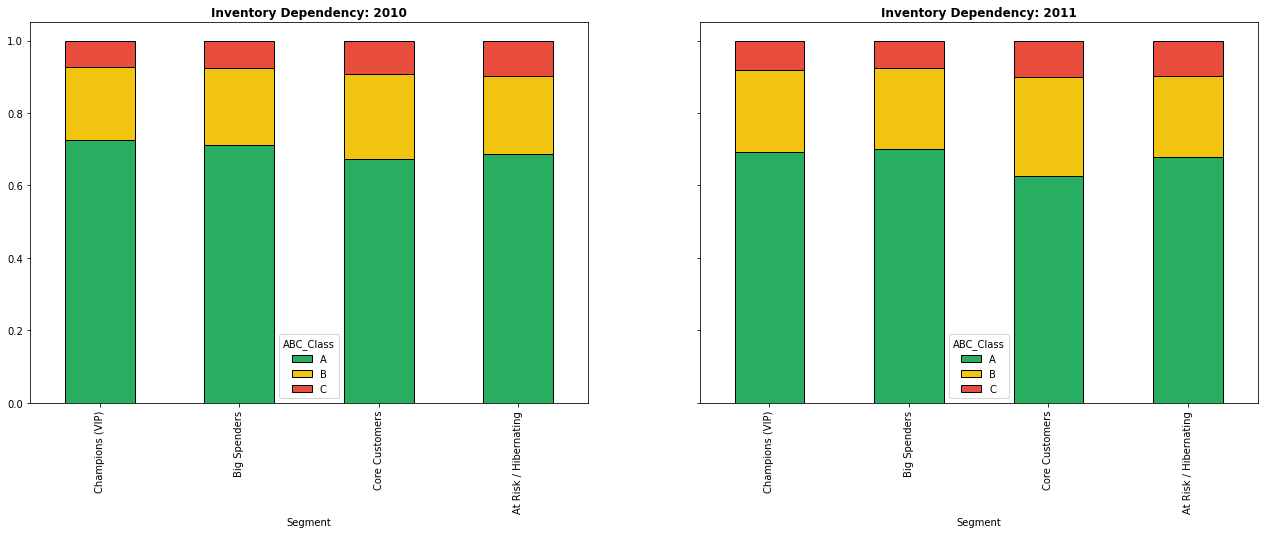

✅ Side-by-Side Longitudinal Analysis Complete. Champions generated 62.7% of 2011 revenue.


In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# =================================================================
# SECTION 1: PROJECT SETUP & DATA PREPARATION
# =================================================================

# 1.1 Path Configuration
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.feature_engineering import (
    add_time_features, calculate_rfm_metrics, 
    prepare_rfm_for_clustering, perform_abc_analysis
)

# 1.2 Data Loading & Year Filtering (Excluding 2009 for stability)
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
df_raw = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])
df_raw['Year'] = df_raw['InvoiceDate'].dt.year

# Create dedicated datasets for each fiscal cycle
df_2010 = add_time_features(df_raw[df_raw['Year'] == 2010].copy())
df_2011 = add_time_features(df_raw[df_raw['Year'] == 2011].copy())

# =================================================================
# SECTION 2: COMPARATIVE LOGISTICS (BAR CHARTS)
# =================================================================

print("📊 Generating Comparative Logistics Bar Charts...")
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, (year_df, yr, color) in enumerate([(df_2010, 2010, 'Blues_d'), (df_2011, 2011, 'Oranges_d')]):
    # Daily Volume
    sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, palette=color, ax=axes[0, i])
    axes[0, i].set_title(f'Logistics Volume by Day: {yr}', fontweight='bold')
    # Hourly Peaks
    sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[1, i])
    axes[1, i].set_title(f'Hourly Operational Peaks: {yr}', fontweight='bold')

plt.tight_layout()
plt.show()

# =================================================================
# SECTION 3: RFM PIPELINE & STRATEGIC SEGMENTATION
# =================================================================

def rfm_pipeline(df_year):
    rfm_year = calculate_rfm_metrics(df_year)
    # Using Quintiles for behavioral scoring
    rfm_year['R_Score'] = pd.qcut(rfm_year['Recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm_year['F_Score'] = pd.qcut(rfm_year['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm_year['M_Score'] = pd.qcut(rfm_year['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    rfm_year[['R_Score', 'F_Score', 'M_Score']] = rfm_year[['R_Score', 'F_Score', 'M_Score']].astype(int)
    
    def assign_segment(row):
        r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
        if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
        elif m >= 4 and r >= 3: return 'Big Spenders'
        elif r <= 2: return 'At Risk / Hibernating'
        else: return 'Core Customers'
    
    rfm_year['Segment'] = rfm_year.apply(assign_segment, axis=1)
    return rfm_year

rfm_2010 = rfm_pipeline(df_2010)
rfm_2011 = rfm_pipeline(df_2011)

# =================================================================
# SECTION 4: AI CLUSTERING & SPATIAL VALIDATION
# =================================================================

def run_clustering(rfm_year):
    scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm_year)
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
    rfm_year['Cluster_ID'] = kmeans.fit_predict(scaled_data)
    return scaled_data, rfm_year, rfm_scaler, kmeans

scaled_2010, rfm_2010, _, _ = run_clustering(rfm_2010)
scaled_2011, rfm_2011, rfm_scaler_2011, kmeans_2011 = run_clustering(rfm_2011)

# 4.1 Comparative 3D Cluster Visualization
fig = plt.figure(figsize=(20, 8))
for i, (scaled, rfm_y, yr) in enumerate([(scaled_2010, rfm_2010, 2010), (scaled_2011, rfm_2011, 2011)]):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    scatter = ax.scatter(scaled['Recency'], scaled['Frequency'], scaled['Monetary'], 
                         c=rfm_y['Cluster_ID'], cmap='viridis', s=40, alpha=0.6)
    ax.set_title(f'3D Cluster Structure: {yr}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Recency'); ax.set_ylabel('Frequency'); ax.set_zlabel('Monetary')
plt.show()

# 4.2 Comparative Convergence Matrix
order = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, (rfm_y, yr) in enumerate([(rfm_2010, 2010), (rfm_2011, 2011)]):
    mtx = pd.crosstab(rfm_y['Segment'], rfm_y['Cluster_ID'], normalize='index') * 100
    sns.heatmap(mtx.reindex(order), annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f'Convergence Matrix: {yr}', fontweight='bold')
plt.show()

# =================================================================
# SECTION 5: INVENTORY & ECONOMIC IMPACT (SIDE-BY-SIDE)
# =================================================================

def process_inventory_impact(df_year, rfm_year):
    # ABC Analysis
    abc_res = perform_abc_analysis(df_year)
    sku_map = abc_res.set_index('Description')['ABC_Class'].to_dict()
    df_year['ABC_Class'] = df_year['Description'].map(sku_map)
    
    # Economic Impact by Segment
    segment_wealth = rfm_year.groupby('Segment')['Monetary'].sum().reset_index()
    segment_wealth['Revenue_%'] = (segment_wealth['Monetary'] / segment_wealth['Monetary'].sum()) * 100
    segment_wealth = segment_wealth.sort_values(by='Revenue_%', ascending=False)
    
    return abc_res, segment_wealth, df_year

abc_2010, wealth_2010, df_2010 = process_inventory_impact(df_2010, rfm_2010)
abc_2011, wealth_2011, df_2011 = process_inventory_impact(df_2011, rfm_2011)

# 5.1 Pareto ABC Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
for i, (abc_y, yr) in enumerate([(abc_2010, 2010), (abc_2011, 2011)]):
    sns.lineplot(data=abc_y, x=abc_y.index, y='Revenue_Share_Pct', ax=axes[i], color='#1B4F72')
    axes[i].axhspan(0, 80, alpha=0.1, color='green', label='Class A')
    axes[i].axhspan(80, 95, alpha=0.1, color='orange', label='Class B')
    axes[i].axhspan(95, 100, alpha=0.1, color='red', label='Class C')
    axes[i].set_title(f'ABC Pareto Curve: {yr}', fontweight='bold')
plt.show()

# 5.2 Economic Impact Comparison (New Visualization)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, (wealth, yr) in enumerate([(wealth_2010, 2010), (wealth_2011, 2011)]):
    sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])
    axes[i].set_title(f'Economic Impact by Segment: {yr} (%)', fontweight='bold')
plt.show()

# =================================================================
# SECTION 4: INVENTORY & ECONOMIC IMPACT TABLES
# =================================================================

def get_economic_impact(df_year, rfm_year):
    # Mapping ABC Classes
    abc_res = perform_abc_analysis(df_year)
    sku_map = abc_res.set_index('Description')['ABC_Class'].to_dict()
    df_year['ABC_Class'] = df_year['Description'].map(sku_map)
    
    # Wealth Concentration by Segment
    wealth = rfm_year.groupby('Segment')['Monetary'].sum().reset_index()
    wealth['Revenue_%'] = (wealth['Monetary'] / wealth['Monetary'].sum()) * 100
    wealth = wealth.sort_values(by='Revenue_%', ascending=False)
    
    return wealth, df_year

wealth_2010, df_2010 = get_economic_impact(df_2010, rfm_2010)
wealth_2011, df_2011 = get_economic_impact(df_2011, rfm_2011)

# DISPLAYING THE IMPACT TABLES (The "Tablitas" you requested)
print("\n💰 --- ECONOMIC IMPACT SUMMARY: 2010 ---")
display(wealth_2010.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

print("\n💰 --- ECONOMIC IMPACT SUMMARY: 2011 ---")
display(wealth_2011.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

# =================================================================
# SECTION 6: ROOT CAUSE & PERSISTENCE
# =================================================================

df_en_2010 = df_2010.merge(rfm_2010[['Segment']], left_on='Customer ID', right_index=True, how='left')
df_en_2011 = df_2011.merge(rfm_2011[['Segment']], left_on='Customer ID', right_index=True, how='left')

# Root Cause Comparison: Inventory Dependency
fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharey=True)
for i, (df_en, yr) in enumerate([(df_en_2010, 2010), (df_en_2011, 2011)]):
    pd.crosstab(df_en['Segment'], df_en['ABC_Class'], normalize='index').reindex(order).plot(
        kind='bar', stacked=True, color=['#27AE60', '#F1C40F', '#E74C3C'], ax=axes[i], edgecolor='black'
    )
    axes[i].set_title(f'Inventory Dependency: {yr}', fontweight='bold')
plt.show()

# 6.3 Save Latest Model (2011)
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(kmeans_2011, os.path.join(models_path, 'rfm_kmeans_2011.pkl'))
joblib.dump(rfm_scaler_2011, os.path.join(models_path, 'rfm_scaler_2011.pkl'))

print(f"✅ Side-by-Side Longitudinal Analysis Complete. Champions generated {wealth_2011.iloc[0]['Revenue_%']:.1f}% of 2011 revenue.")

📉 Deflating 2011 values to Constant 2010 Prices (Inflation: 3.9%)...
📊 Generating Logistics Volume Comparison...


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\4023777839.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, palette=color, ax=axes[0, i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\4023777839.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[1, i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_10508\4023777839.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, p

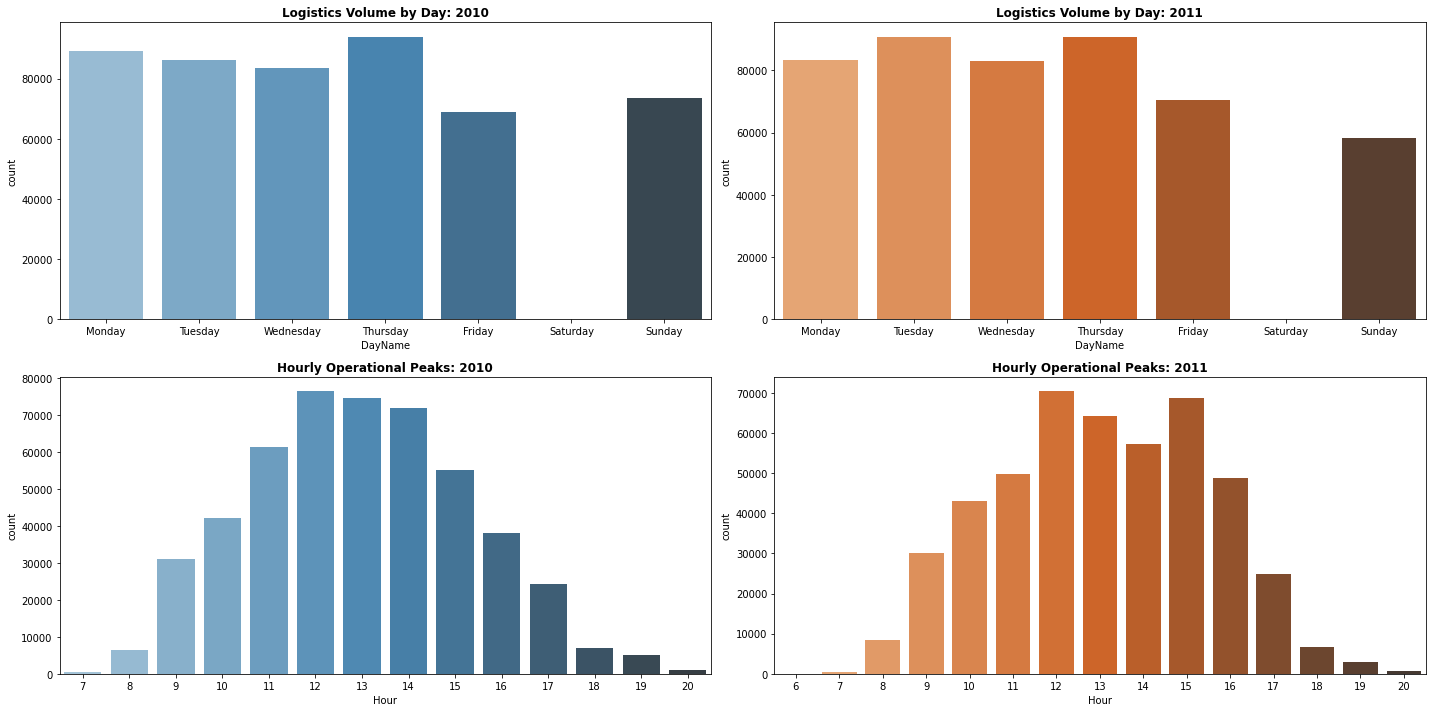

✅ RFM Metrics calculated successfully.
✅ RFM Metrics calculated successfully.


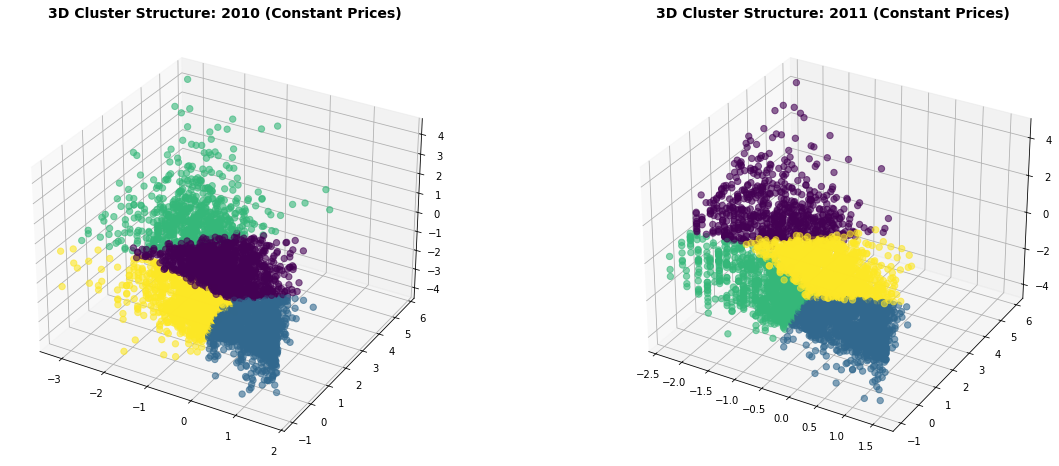

✅ ABC Analysis calculation complete.
✅ ABC Analysis calculation complete.

💰 --- IMPACT SUMMARY 2010 (Base) ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£4,269,543.27",62.2%
0,At Risk / Hibernating,"£1,113,011.09",16.2%
1,Big Spenders,"£945,809.51",13.8%
3,Core Customers,"£537,012.23",7.8%



💰 --- IMPACT SUMMARY 2011 (Constant 2010 Prices) ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£3,865,851.37",62.7%
0,At Risk / Hibernating,"£962,258.07",15.6%
1,Big Spenders,"£872,869.55",14.2%
3,Core Customers,"£466,259.14",7.6%


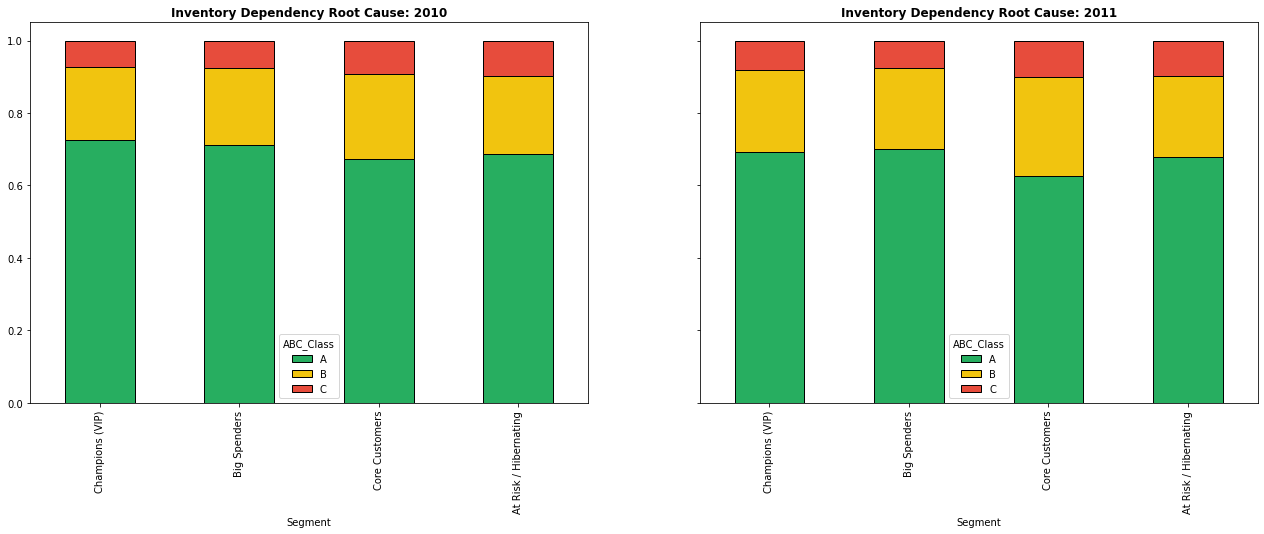

✅ Side-by-Side Analysis Complete. Values for 2011 adjusted for 3.9% inflation.


In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# =================================================================
# SECTION 1: PROJECT SETUP & ECONOMETRIC DEFLATION
# =================================================================

# 1.1 Path Configuration
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# 1.2 Import YOUR Custom Logic from src
from src.feature_engineering import (
    add_time_features, calculate_rfm_metrics, 
    prepare_rfm_for_clustering, perform_abc_analysis
)

# 1.3 Data Loading & Cleaning
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
df_raw = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])

# Ensure TotalSum exists before splitting and deflating
# Using 'Price' or 'UnitPrice' depending on your cleaned dataset
if 'TotalSum' not in df_raw.columns:
    df_raw['TotalSum'] = df_raw['Quantity'] * df_raw['Price']

df_raw['Year'] = df_raw['InvoiceDate'].dt.year

# 1.4 Inflation Adjustment (Base Year: 2010)
# We deflate 2011 values by 3.9% to reach constant 2010 prices
INFLATION_2011 = 0.039

df_2010 = df_raw[df_raw['Year'] == 2010].copy()
df_2011 = df_raw[df_raw['Year'] == 2011].copy()

print(f"📉 Deflating 2011 values to Constant 2010 Prices (Inflation: {INFLATION_2011*100}%)...")
df_2011['TotalSum'] = df_2011['TotalSum'] / (1 + INFLATION_2011)
df_2011['Price'] = df_2011['Price'] / (1 + INFLATION_2011)

# Apply your temporal features from src
df_2010 = add_time_features(df_2010)
df_2011 = add_time_features(df_2011)

# =================================================================
# SECTION 2: COMPARATIVE LOGISTICS (BAR CHARTS)
# =================================================================

print("📊 Generating Logistics Volume Comparison...")
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, (year_df, yr, color) in enumerate([(df_2010, 2010, 'Blues_d'), (df_2011, 2011, 'Oranges_d')]):
    sns.countplot(data=year_df, x='DayName', order=DAYS_ORDER, palette=color, ax=axes[0, i])
    axes[0, i].set_title(f'Logistics Volume by Day: {yr}', fontweight='bold')
    sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[1, i])
    axes[1, i].set_title(f'Hourly Operational Peaks: {yr}', fontweight='bold')

plt.tight_layout()
plt.show()

# =================================================================
# SECTION 3: RFM & AI CLUSTERING PIPELINE
# =================================================================

def process_year_intelligence(df_year):
    # Calculate RFM using your src function
    rfm_year = calculate_rfm_metrics(df_year)
    
    # Clustering Preparation (Log + Scaling) from src
    scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm_year)
    
    # Final Model Execution
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
    rfm_year['Cluster_ID'] = kmeans.fit_predict(scaled_data)
    
    # Manual Strategic Labeling for Validation
    rfm_year['R_Score'] = pd.qcut(rfm_year['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
    rfm_year['F_Score'] = pd.qcut(rfm_year['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
    rfm_year['M_Score'] = pd.qcut(rfm_year['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    
    def assign_segment(row):
        r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
        if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
        elif m >= 4 and r >= 3: return 'Big Spenders'
        elif r <= 2: return 'At Risk / Hibernating'
        else: return 'Core Customers'
    
    rfm_year['Segment'] = rfm_year.apply(assign_segment, axis=1)
    
    return rfm_year, scaled_data, rfm_scaler, kmeans

rfm_2010, scaled_2010, _, _ = process_year_intelligence(df_2010)
rfm_2011, scaled_2011, scaler_2011, model_2011 = process_year_intelligence(df_2011)

# 3.1 Side-by-Side 3D Visuals
fig = plt.figure(figsize=(20, 8))
for i, (scaled, rfm_y, yr) in enumerate([(scaled_2010, rfm_2010, 2010), (scaled_2011, rfm_2011, 2011)]):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.scatter(scaled['Recency'], scaled['Frequency'], scaled['Monetary'], 
               c=rfm_y['Cluster_ID'], cmap='viridis', s=40, alpha=0.6)
    ax.set_title(f'3D Cluster Structure: {yr} (Constant Prices)', fontsize=14, fontweight='bold')
plt.show()

# =================================================================
# SECTION 4: INVENTORY & ECONOMIC IMPACT (CONSTANT £)
# =================================================================

def run_economic_impact(df_year, rfm_year):
    # ABC Analysis from src
    abc_res = perform_abc_analysis(df_year)
    sku_map = abc_res.set_index('Description')['ABC_Class'].to_dict()
    df_year['ABC_Class'] = df_year['Description'].map(sku_map)
    
    # Wealth Impact
    wealth = rfm_year.groupby('Segment')['Monetary'].sum().reset_index()
    wealth['Revenue_%'] = (wealth['Monetary'] / wealth['Monetary'].sum()) * 100
    wealth = wealth.sort_values(by='Revenue_%', ascending=False)
    
    return abc_res, wealth, df_year

abc_2010, wealth_2010, df_2010 = run_economic_impact(df_2010, rfm_2010)
abc_2011, wealth_2011, df_2011 = run_economic_impact(df_2011, rfm_2011)

print("\n💰 --- IMPACT SUMMARY 2010 (Base) ---")
display(wealth_2010.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

print("\n💰 --- IMPACT SUMMARY 2011 (Constant 2010 Prices) ---")
display(wealth_2011.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

# =================================================================
# SECTION 5: ROOT CAUSE ANALYSIS & PERSISTENCE
# =================================================================

# Enrichment
df_en_2010 = df_2010.merge(rfm_2010[['Segment']], left_on='Customer ID', right_index=True, how='left')
df_en_2011 = df_2011.merge(rfm_2011[['Segment']], left_on='Customer ID', right_index=True, how='left')

# Root Cause Inventory Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharey=True)
order = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']

for i, (df_en, yr) in enumerate([(df_en_2010, 2010), (df_en_2011, 2011)]):
    pd.crosstab(df_en['Segment'], df_en['ABC_Class'], normalize='index').reindex(order).plot(
        kind='bar', stacked=True, color=['#27AE60', '#F1C40F', '#E74C3C'], ax=axes[i], edgecolor='black'
    )
    axes[i].set_title(f'Inventory Dependency Root Cause: {yr}', fontweight='bold')
plt.show()

# Save the 2011 Brain
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(model_2011, os.path.join(models_path, 'rfm_kmeans_2011.pkl'))
joblib.dump(scaler_2011, os.path.join(models_path, 'rfm_scaler_2011.pkl'))

print(f"✅ Side-by-Side Analysis Complete. Values for 2011 adjusted for 3.9% inflation.")